## Restructure Data Analysis Framework

***

In [1]:
import pandas as pd
import numpy as np

from data_protection_functions import *
from data_processing_functions import *

# nice time series plots
from sktime.utils.plotting import plot_series

# import detrender and deseasonalizer
from sktime.transformations.series.detrend import Detrender

# import exponential smoothing forecasting model
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

import sktime
import lightgbm

### Step 1: Import Time Series Data

In [2]:
# import weekly finance time series
# ignore header and skip the first row to use integers as column names
Full_data = pd.read_csv("../../Data/Train/Clean/weekly_finance_clean.csv", header=None, skiprows=1)
Y, Test = Full_data.iloc[:,:-20], Full_data.iloc[:,-20:]

***

### Step 2: Apply Data Protection to Generate Protected Series

At the end of this step, we will have two time series datasets:

* Confidential (original) dataset
* Protected dataset

In [3]:
Y_protected = apply_data_protection(Y, epsilon=4.6)

***

### Step 3: Pre-process the Confidential and Sensitive Datasets

In [4]:
transform_dict = {"windows":{"window_length":8, "h":3}}
# transform_dict = None

In [5]:
X_train, last_window = reduce_train_test_global(train_data=np.array(Y), window_length=8, h=3)

In [6]:
Y.iloc[:,-8:]

,219,220,221,222,223,224,225,226
0,10780.44,10742.64,10723.13,10713.97,10681.56,10686.59,10704.66,10684.96
1,3835.10,3715.80,3715.80,3575.10,3575.10,3449.90,3449.90,3796.60
2,913.30,976.00,977.70,1007.70,965.50,931.20,996.40,1054.50
3,913.30,976.00,977.70,1007.70,965.50,931.20,996.40,1054.50
4,2442.00,2392.00,2477.00,2541.00,2617.00,2577.00,2522.00,2483.00
...,...,...,...,...,...,...,...,...
159,1085.00,1078.00,1092.00,1085.00,1078.00,1092.00,1085.00,1078.00
160,1785.00,1778.00,1820.00,1813.00,1806.00,1799.00,1792.00,1786.00
161,2462.90,2468.20,2543.30,2490.50,2423.60,2533.40,2781.30,2468.50
162,1906.00,1690.10,1759.70,1980.20,1880.70,1734.20,1754.80,1853.50


In [7]:
last_window

,0,1,2,3,4,5,6,7
0,2.401750e+01,-1.874286,-9.476071,-6.727857,-27.229643,-10.291429,19.686786,11.895000
1,9.607500e+01,5.307143,33.839286,-78.328571,-49.796429,-146.464286,-117.932143,257.300000
2,-2.662500e+01,25.257143,16.139286,35.321429,-17.696429,-62.814286,-8.432143,38.850000
3,-2.662500e+01,25.257143,16.139286,35.321429,-17.696429,-62.814286,-8.432143,38.850000
4,-9.666667e+00,-75.297619,-5.928571,42.440476,102.809524,47.178571,-23.452381,-78.083333
...,...,...,...,...,...,...,...,...
159,6.821210e-13,-6.750000,7.500000,0.750000,-6.000000,8.250000,1.500000,-5.250000
160,-1.208333e+01,-19.166667,22.750000,15.666667,8.583333,1.500000,-5.583333,-11.666667
161,4.275000e+00,-8.378571,48.767857,-21.985714,-106.839286,-14.992857,214.953571,-115.800000
162,7.693333e+01,-136.347619,-64.128571,158.990476,62.109524,-81.771429,-58.552381,42.766667


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='0'>)

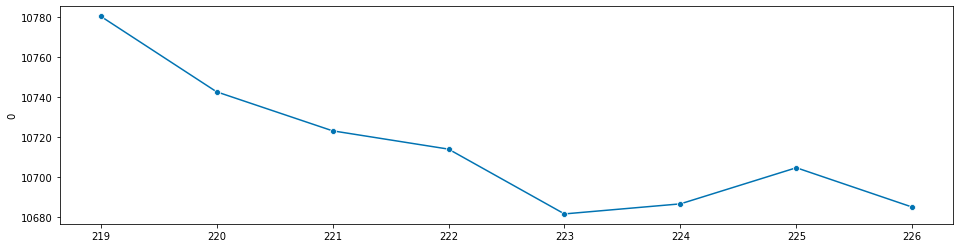

In [10]:
plot_series(Y.iloc[0,-8:])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='0'>)

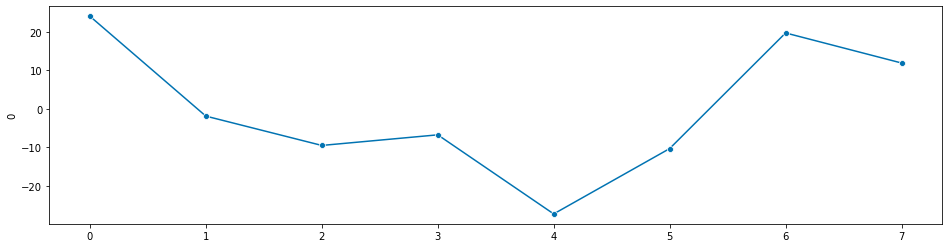

In [11]:
plot_series(last_window.iloc[0,:])

In [ ]:
# just implemented detrending and last window in reduce train-test global
# next need to implement it all in pre-processing and start train and forecasting

In [ ]:
Y_processed = pre_process(Y, truncate=True, log=True, transform_dict=transform_dict)
Y_protected_processed = pre_process(Y_protected, truncate=True, log=True, transform_dict=transform_dict)

### Step 4: Train Models and Generate Forecasts

In [ ]:
def train_and_forecast(ts_data, forecasting_model, horizon_length):
    """
    Performs model training and forecasting using the supplied model applied to the supplied time series data.

    :param ts_data: pandas dataframe containing EITHER
        - series in the rows and time periods in the columns - used with traditional forecasting models.
        - reduced tabular data with target feature in the last column.
    :param forecasting_model: the model to use to perform forecasts. Must have .fit and .predict methods
    :param horizon_length: the number of steps ahead you with to forecast relative to the last point in the series
    :return fcasts: a pandas dataframe containing forecasts for all series, dimensions are transposed relative to the
        input data - series are in the columns, each row corresponds to a time period.
    """

    # define sktime relative forecasting horizon
    h = np.arange(1, horizon_length+1)

    # list to store forecasts
    fcasts = []
    
    # if using an exponential smoothing model,
    if type(forecasting_model) == sktime.forecasting.exp_smoothing.ExponentialSmoothing:
        
        fcasts = ts_data.apply(lambda x: forecasting_model.fit(x).predict(h), axis=1).T
        
    # if using an LGBM,
    elif type(forecasting_model) == lgb.sklearn.LGBMRegressor:

        # store number of time series and number of time periods
        num_series, num_periods = training_data.shape
        # reduced train and test data
        X_train, Y_train = reduce_train_test_global(train_data=np.array(training_data), window_length=window_length, h=horizon_length)
        # train global model
        forecasting_model.fit(X_train, Y_train)
        # select last window of training data
        ## this is equivalent to the last row of x_train rolled forward to include the last value of Y_train
        last_window = training_data.iloc[:,-window_length:]

        ## generate forecasts ##

        # store forecasted value based on last window of training data
        last_prediction = forecasting_model.predict(last_window)
        for i in range(horizon_length):
            # add latest forecast
            fcasts.append(last_prediction)
            # roll window forward one period (places first value in window at the end)
            last_window = np.roll(last_window, -1)
            # replace the end value (used to be first value) with the latest forecast
            last_window[:,-1] = last_prediction
            # forecast for next period
            last_prediction = forecasting_model.predict(last_window)

        # combine forecasts into (num_series, horizon_length) shaped array
        fcasts = np.concatenate([i.reshape(num_series, 1) for i in fcasts], axis=1)

        # convert forecasts into a list of pandas series
        fcasts = [pd.Series(i, index=np.arange(num_periods, num_periods+horizon_length)) for i in fcasts]

    return fcasts

In [ ]:
forecasting_model = lightgbm.LGBMRegressor()

In [ ]:
 # define sktime relative forecasting horizon
h = np.arange(1, 5+1)

In [ ]:
# if using an LGBM,
elif type(forecasting_model) == lgb.sklearn.LGBMRegressor:
    # store number of time series and number of time periods
    # num_series, num_periods = training_data.shape
    # reduced train and test data
    # X_train, Y_train = reduce_train_test_global(train_data=np.array(training_data), window_length=window_length, h=horizon_length)
    # train global model
    forecasting_model.fit(X_train, Y_train)
    # select last window of training data
    ## this is equivalent to the last row of x_train rolled forward to include the last value of Y_train
    last_window = training_data.iloc[:,-window_length:]

    ## generate forecasts ##

    # store forecasted value based on last window of training data
    last_prediction = forecasting_model.predict(last_window)
    for i in range(horizon_length):
        # add latest forecast
        fcasts.append(last_prediction)
        # roll window forward one period (places first value in window at the end)
        last_window = np.roll(last_window, -1)
        # replace the end value (used to be first value) with the latest forecast
        last_window[:,-1] = last_prediction
        # forecast for next period
        last_prediction = forecasting_model.predict(last_window)

    # combine forecasts into (num_series, horizon_length) shaped array
    fcasts = np.concatenate([i.reshape(num_series, 1) for i in fcasts], axis=1)

    # convert forecasts into a list of pandas series
    fcasts = [pd.Series(i, index=np.arange(num_periods, num_periods+horizon_length)) for i in fcasts]

In [ ]:
Y_processed

In [ ]:
forecasting_model.fit(X_train, Y_train)

In [ ]:
## this is equivalent to the last row of x_train rolled forward to include the last value of Y_train
last_window = Y.iloc[:,-window_length:]

In [ ]:
### figure out where to output the last window of training data to use for forecasting
# could do it in the global reduce function

In [ ]:
# need to include de-trending prior to extracting the last window